In [14]:
import numpy as np
import copy
import sys
import helper
import cardinal_functions
from tensorflow_probability import distributions as tfd
import tensorflow as tf
import models
import matplotlib.pyplot as plt
# will be depreciated:
#import calc_mllh
# new analysis file
from functions_for_2task import calc_mmllh_1task
from functions_for_2task import calc_mmllh_2task
import eval_learning
import pickle

Basic definitions for consistent visualizations

In [15]:
colorPalette1 = np.array([
    [221/255,97/255,74/255],
    [244/255,134/255,104/255],
    [244/255,166/255,152/255],
    [197/255,195/255,146/255],
    [115/255,165/255,128/255]
])

colorPalette2 = np.array([
    [82,65,76],
    [89,97,87],
    [91,140,90],
    [207,209,134],[227,101,91]
])/255

colorPalette3 = np.array([
    [134,186,144],[166,216,212],[65,39,34],[223,160,110],[223,41,53]
])/255

colorPalette=colorPalette3

modelColors = [['x', colorPalette[0]], 
               ['y', colorPalette[1]],
              ['1x2D', colorPalette[2]],
              ['2x1D', colorPalette[3]],
              ['2x2D', colorPalette[4]]]

modelIDs={"x":0, "y":1, "1x2D":2, "2x1D":3, "2x2D":4}

**Comaparison of models with and without context marginalization on an example diagonal data set**
* a small block size is applied
* effect of $\sigma_r$ can be explored
* $\log \mathcal{D}(z|M_i)$ is explored with analytical evaluation of marginalization (no particle filtering)

2x2D, no bg: -6.770416027370843
2x2D, w bg:  -6.711030675959097
x:           -9.223595100174498
y:           -5.962312674601414
1x2D:        -6.711030675959097


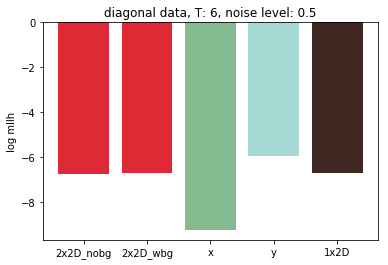

In [16]:
blockSize=3
sigma_r=0.5
d1 = helper.generate_data(N=blockSize,alpha=45)
d2 = helper.generate_data(N=blockSize,alpha=-45)
dShort = helper.concatenate_data(d1,d2)
m, p = calc_mmllh_2task(dShort, sigma_r, model="2x2D", evaluation = "full", num_particles = 256, marginalize = True)
mllh2x2D_nobg = np.log(m)
print("2x2D, no bg:",mllh2x2D_nobg)
m, p, cs= calc_mmllh_2task(dShort, sigma_r, model="2x2D",evaluation = "full", num_particles = 256, marginalize = False)
mllh2x2D_wbg = np.sum(np.log(m))
print("2x2D, w bg: ", mllh2x2D_wbg)
m, p = calc_mmllh_1task(dShort, sigma_r, model = "x")
mllhx = np.log(m)
print("x:          ", mllhx)
m, p = calc_mmllh_1task(dShort, sigma_r, model = "y")
mllhy = np.log(m)
print("y:          ", mllhy)
m, p = calc_mmllh_1task(dShort, sigma_r, model = "1x2D")
mllh1x2D = np.log(m)
print("1x2D:       ", mllh1x2D)
model_names = ['2x2D_nobg', '2x2D_wbg', 'x', 'y', '1x2D']
model_mllhs=np.array([mllh2x2D_nobg, mllh2x2D_wbg, mllhx, mllhy, mllh1x2D])
plt.bar(model_names, model_mllhs,color=[modelColors[4][1], modelColors[4][1], modelColors[0][1], modelColors[1][1], modelColors[2][1]])
plt.ylabel('log mllh')
#plt.title(print("aa", mllhy))
plt.title("diagonal data, T: " + str(blockSize*2) + ", noise level: " + str(sigma_r))
plt.show()

*** ***
**EXPERIMENT: rotated data**

**directly contrasting the effect of task complexity**

* Using a **single dataset** in which blocks of trials from the two tasks are alternating we prepare both a cardinal and diagonal setting by **rotating individual data points** by 45 degrees
* We assess all alternative models
* marginalization is performed using **PF**
* background is either **observed or marginalized**

In [17]:
# joint dataset for the two tasks
blockSize=5
blockNo=2
d1 = helper.generate_data(N=blockSize,alpha=90)
d2 = helper.generate_data(N=blockSize,alpha=0)
d = helper.concatenate_data(d1,d2)
for i in range(0,blockNo-1):
    d1 = helper.generate_data(N=blockSize,alpha=90)
    d = helper.concatenate_data(d,d1)
    d2 = helper.generate_data(N=blockSize,alpha=0)
    d = helper.concatenate_data(d,d2)

T=np.size(d["z"],0)
dCard = copy.deepcopy(d)

dDiag = copy.deepcopy(d)

rotationOperator=np.array([2,2])
rotationOperator=[[np.cos(np.pi/4), -np.cos(np.pi/4)],[np.sin(np.pi/4), np.cos(np.pi/4)]]
for i in range(0,T):
    dDiag["z"][i]=np.dot(rotationOperator,dDiag["z"][i])


In [18]:
# assessing mmllhs for the two task difficulties
sigma_r=0.6

evalModels = ["x","y", "1x2D", "2x1D"]
mllhCardwbg, pred_prob = eval_learning.learnGT(dCard,sigma_r,model_set=evalModels,marginalize=False)
evalModels = ["x","y", "1x2D", "2x2D"]
mllhDiagwbg, pred_prob = eval_learning.learnGT(dDiag,sigma_r,model_set=evalModels,marginalize=False)

evalModels = ["x","y", "1x2D", "2x1D"]
mllhCardnobg, pred_prob = eval_learning.learnGT(dCard,sigma_r,model_set=evalModels,marginalize=True)
evalModels = ["x","y", "1x2D", "2x2D"]
mllhDiagnobg, pred_prob = eval_learning.learnGT(dDiag,sigma_r,model_set=evalModels,marginalize=True)


/Users/davidnagy/GitHub/Continual-learning-with-structure-learning/functions_for_2task.py:578: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  x_indices = np.where(np.array(c) == '90')[0]


ValueError: too many values to unpack (expected 4)

In [51]:
#with open('exp_rotated_data.pkl', 'wb') as f:  
#    pickle.dump([dDiag, dCard, mllhCardwbg, mllhDiagwbg, mllhCardnobg, mllhDiagnobg], f)

#with open('exp_rotated_data.pkl', 'rb') as f:
#    dDiag, dCard, mllhCardwbg, mllhDiagwbg, mllhCardnobg, mllhDiagnobg = pickle.load(f)

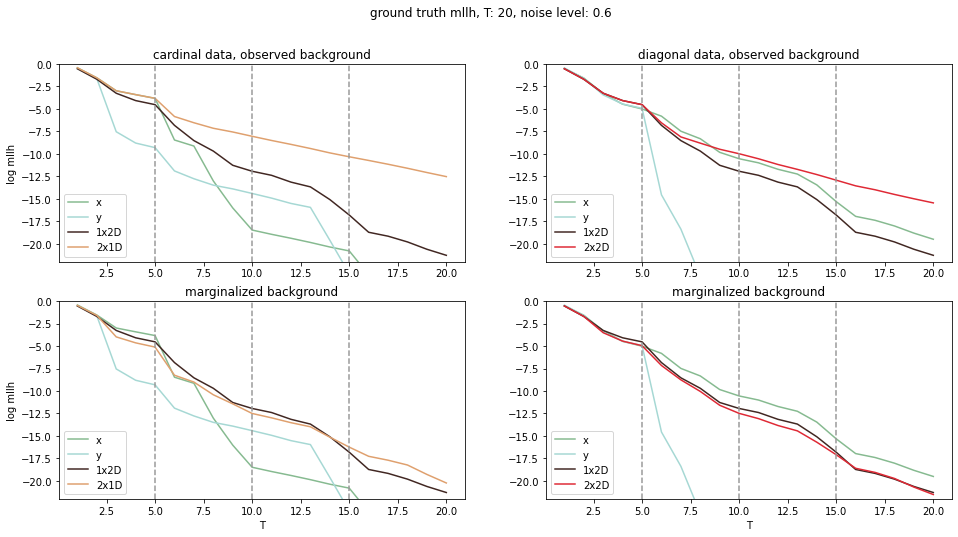

In [52]:
# visualizing differences
#ymin = np.floor(np.min(np.log([mllhCardwbg, mllhDiagwbg, mllhCardnobg, mllhDiagnobg])))
ymin=-22

fig, ax = plt.subplots(2, 2)
fig.suptitle("ground truth mllh, T: " + str(T) + ", noise level: " + str(sigma_r))

# cardinal, observed
plottedModels = ["x","y", "1x2D", "2x1D"]

for modelID in plottedModels:
    modelID
    ax[0,0].plot(range(1,T+1),np.log(mllhCardwbg[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)])
ax[0,0].legend(plottedModels, loc ="lower left")
ax[0,0].set(title="cardinal data, observed background", ylabel="log mllh", ylim=[ymin,0])

i=blockSize
while i < T:
    ax[0,0].plot([i,i],[ymin, 0],'--', color=[0.6, 0.6, 0.6])
    i = i + blockSize

# diagonal, observed
plottedModels = ["x","y", "1x2D", "2x2D"]

for modelID in plottedModels:
    ax[0,1].plot(range(1,T+1),np.log(mllhDiagwbg[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)])
ax[0,1].legend(plottedModels, loc ="lower left")
ax[0,1].set(title="diagonal data, observed background", ylim=[ymin,0])

i=blockSize
while i < T:
    ax[0,1].plot([i,i],[ymin, 0],'--', color=[0.6, 0.6, 0.6])
    i = i + blockSize

# cardinal, marginalized
plottedModels = ["x","y", "1x2D", "2x1D"]

for modelID in plottedModels:
    modelID
    ax[1,0].plot(range(1,T+1),np.log(mllhCardnobg[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)])
ax[1,0].legend(plottedModels, loc ="lower left")
ax[1,0].set(title="marginalized background", xlabel='T', ylabel="log mllh", ylim=[ymin,0])

i=blockSize
while i < T:
    ax[1,0].plot([i,i],[ymin, 0],'--', color=[0.6, 0.6, 0.6])
    i = i + blockSize

# diagonal, marginalized
plottedModels = ["x","y", "1x2D", "2x2D"]

for modelID in plottedModels:
    ax[1,1].plot(range(1,T+1),np.log(mllhDiagnobg[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)])
ax[1,1].legend(plottedModels, loc ="lower left")
ax[1,1].set(title="marginalized background", xlabel='T', ylim=[ymin,0])

i=blockSize
while i < T:
    ax[1,1].plot([i,i],[ymin, 0],'--', color=[0.6, 0.6, 0.6])
    i = i + blockSize


fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [22]:
#fig.savefig('exp_rotated_data.png', facecolor=fig.get_facecolor(), transparent=False)

****
**EXPLORATION**

**Testing how predictive probability evolves**

In [5]:
blockSize=10
#x model is associated with context 0, while the y model is associated with context_value 1
d1 = helper.generate_data(N=blockSize,alpha=45)
d2 = helper.generate_data(N=blockSize,alpha=-45)
d = helper.concatenate_data(d1,d2)
T=np.size(d["z"],0)

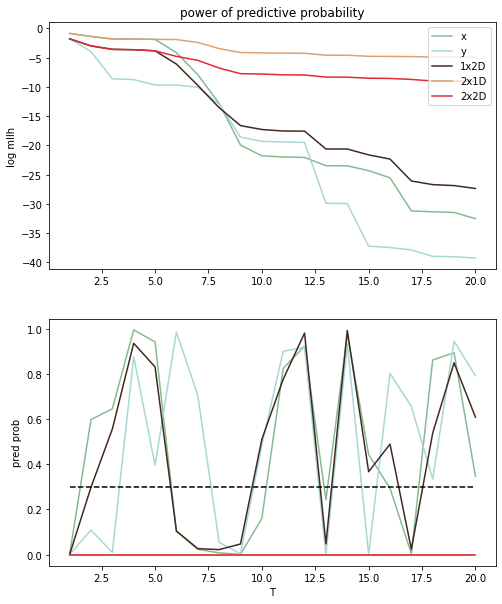

In [53]:
sigma_r=0.4
evalModels = ["x","y", "1x2D", "2x1D", "2x2D"]
mllh, pred_prob = eval_learning.learnGT(d,sigma_r,model_set=evalModels, marginalize=False)

plottedModels = evalModels

fig, (ax1, ax2) = plt.subplots(2, 1)
for modelID in plottedModels:
    ax1.plot(range(1,T+1),np.log(mllh[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)])
    ax2.plot(range(1,T+1),pred_prob[modelIDs.get(modelID)],color=colorPalette[modelIDs.get(modelID)])
ax1.legend(plottedModels, loc ="upper right")

ax1.set(title="power of predictive probability", ylabel="log mllh")

ax2.plot([1,T],[0.3, 0.3],'k--')
ax2.set(xlabel='T', ylabel="pred prob")

fig.set_figwidth(8)
fig.set_figheight(10)


**Here we run some tests with the new frontnd function that calculates model marginal likelihood for two task models**

In [3]:
data1 = helper.generate_data(8, alpha = 45)
data2 = helper.generate_data(8, alpha = -45)
data = helper.concatenate_data(data1, data2)


In [ ]:
sigma_r = .3
task_complexity = "2x1D"
marginalize = True
num_particles = 256
evaluation = "full"
mllh2, posterior_test = calc_mllh.calc_mmllh_2task(data, sigma_r, task_complexity, evaluation = evaluation, num_particles = num_particles, marginalize = marginalize)
mllh_test

In [25]:
data1 = helper.generate_data(10, alpha = 90)
data2 = helper.generate_data(1, alpha = 0)
data = helper.concatenate_data(data1, data2)

sigma_r = .3
marginalize = False
num_particles = 256
evaluation = "full"
mllhd1m1, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data1, sigma_r, model="x", evaluation = evaluation, Sigma_0=1)
mllhd1m2, posterior_test = calc_mllh.calc_mmllh_2task(data1, sigma_r, model="2x1D", evaluation = evaluation, num_particles = num_particles, marginalize = marginalize)

mllhd2m1, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data, sigma_r, model="x", evaluation = evaluation, Sigma_0=1)
mllhd2m2, posterior_test = calc_mllh.calc_mmllh_2task(data, sigma_r, model="2x1D", evaluation = evaluation, num_particles = num_particles, marginalize = marginalize)

mllhs=[["single-task data", [mllhd1m1, mllhd1m2]], ["dual-task data", [mllhd2m1, mllhd2m2]]]
mllhs

[['single-task data', [1.5912935780127748, 1.5912935780127748]],
 ['dual-task data', [1.353467810603101e-08, 2.561387130485631e-10]]]

* diagonal data

In [27]:
data1 = helper.generate_data(10, alpha = -45)
data2 = helper.generate_data(1, alpha = 45)
data = helper.concatenate_data(data1, data2)

sigma_r = .3
marginalize = False
num_particles = 256
evaluation = "full"
mllhd1m1, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data1, sigma_r, model="1x2D", evaluation = evaluation, Sigma_0=[[1, 0],[0,1]])
mllhd1m2, posterior_test = calc_mllh.calc_mmllh_2task(data1, sigma_r, model="2x2D", evaluation = evaluation, num_particles = num_particles, marginalize = marginalize)

mllhd2m1, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data, sigma_r, model="1x2D", evaluation = evaluation, Sigma_0=[[1, 0],[0,1]])
mllhd2m2, posterior_test = calc_mllh.calc_mmllh_2task(data, sigma_r, model="2x2D", evaluation = evaluation, num_particles = num_particles, marginalize = marginalize)

mllhs=[["single-task data", [mllhd1m1, mllhd1m2]], ["dual-task data", [mllhd2m1, mllhd2m2]]]
mllhs

[['single-task data', [0.09941348898641753, 0.09941348898641753]],
 ['dual-task data', [0.05366836648772355, 0.08715290306951064]]]

****
**Testing the basic relationship between data and mllhs**

In [17]:
data1 = helper.generate_data(10, alpha = 45)
data2 = helper.generate_data(10, alpha = -45)
data = helper.concatenate_data(data1, data2)

sigma_r=0.3

mllhx, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data, sigma_r, model="x", evaluation = "full", Sigma_0=1)
print("x model:   ", np.log(mllhx))
mllhy, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data, sigma_r, model="y", evaluation = "full", Sigma_0=1)
print("y model:   ", np.log(mllhy))
mllh2x1D, p = calc_mllh.calc_mmllh_2task(data, sigma_r, model="2x1D", evaluation = "full", num_particles = 256, marginalize = False)
print("2x1D model:", np.log(mllh2x1D))
print("")
mllh1x2D, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(data, sigma_r, model="1x2D", evaluation = "full", Sigma_0=[[1,0],[0,1]])
print("1x2D model:", np.log(mllh1x2D))
mllh2x2D, p = calc_mllh.calc_mmllh_2task(data, sigma_r, model="2x2D", evaluation = "full", num_particles = 256, marginalize = False)
print("2x2D model:", np.log(mllh2x2D))

x model:    -128.5416308509267
y model:    -39.93063604206484
2x1D model: -39.93063604206484

1x2D model: -41.65686830993987
2x2D model: -4.776852465499302


**Testing basic behavior of GR**

In [16]:
data1 = helper.generate_data(5, alpha = 45)
data2 = helper.generate_data(5, alpha = 45)
data = helper.concatenate_data(data1, data2)

sigma_r=0.5

#mllhGT, muGT, SigmaGT = calc_mllh.calc_mmllh_1task(data, sigma_r, model="x", evaluation = "full", Sigma_0=1)
#print("x model, GT:", np.log(mllhGT))
mllhGT, muGT, SigmaGT = calc_mllh.calc_mmllh_1task(data, sigma_r, model="1x2D", evaluation = "full", Sigma_0=[[1,0],[0,1]])
print("1x2D model, GT:", np.log(mllhGT))

dataGR = eval_learning.dream_data_from_posterior(model = "1x2D", T=10, mu = muGT, Sigma = SigmaGT)

mllhx, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(dataGR, sigma_r, model="x", evaluation = "full", Sigma_0=1)
print("x model:   ", np.log(mllhx))
mllhy, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(dataGR, sigma_r, model="y", evaluation = "full", Sigma_0=1)
print("y model:   ", np.log(mllhy))
mllh2x1D, p = calc_mllh.calc_mmllh_2task(dataGR, sigma_r, model="2x1D", evaluation = "full", num_particles = 256, marginalize = False)
print("2x1D model:", np.log(mllh2x1D))
print("")
mllh1x2D, mu1, Sigma1 = calc_mllh.calc_mmllh_1task(dataGR, sigma_r, model="1x2D", evaluation = "full", Sigma_0=[[1,0],[0,1]])
print("1x2D model:", np.log(mllh1x2D))
mllh2x2D, p = calc_mllh.calc_mmllh_2task(dataGR, sigma_r, model="2x2D", evaluation = "full", num_particles = 256, marginalize = False)
print("2x2D model:", np.log(mllh2x2D))

1x2D model, GT: -7.352182663423546
x model:    -16.26822466676088
y model:    -22.063991658685474
2x1D model: -22.063991658685474

1x2D model: -7.334989121146587
2x2D model: -7.334989121146587


/mnt/repositories (local)/Continual-learning-with-structure-learning/calc_mllh.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  x_indices = np.where(np.array(c) == '90')[0]


*****
**EXPERIMENT**

**testing GR against GT on a 1-task diagonal data**

In [3]:
data1 = helper.generate_data(6, alpha = 45)
data2 = helper.generate_data(6, alpha = 45)
data = helper.concatenate_data(data1, data2)
T=np.size(data["z"],0)

In [6]:
sigma_r=0.9

competingModels = ["x", "y", "1x2D"]
competingModelIDs = [0, 1, 2]
mllhGT, pred_prob = eval_learning.learnGT(data,sigma_r,model_set=competingModels,marginalize=False)

mllhGR, evolvingModelGR = eval_learning.learnGR(data, 20, sigma_r,model_set=competingModels)
evolvingModelGR

['y', 'y', 'x', 'y', '1x2D', '1x2D', 'y', 'x', 'x', 'y', 'y', '1x2D']

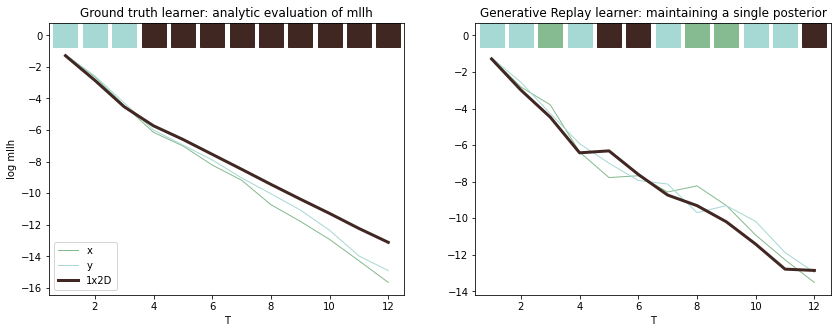

In [7]:
plottedModels = competingModels

trueModel = "1x2D"

fig, (ax1, ax2) = plt.subplots(1,2)

for modelID in plottedModels:
    if modelID == trueModel:
        lw = 3
    else:
        lw = 1
    ax1.plot(range(1,T+1),np.log(mllhGT[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
    ax2.plot(range(1,T+1),np.log(mllhGR[competingModels.index(modelID)]),color=colorPalette[competingModels.index(modelID)], linewidth=lw)
ax1.legend(plottedModels, loc ="lower left")

ax1.set(title="Ground truth learner: analytic evaluation of mllh", ylabel="log mllh", xlabel="T")
ax2.set(title="Generative Replay learner: maintaining a single posterior", xlabel="T")

for t in range(0,T):
    ax1.plot(t+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGT[competingModelIDs,t])])], markersize = 24)
    ax2.plot(t+1,0, 's', color=colorPalette[modelIDs.get(evolvingModelGR[t])], markersize = 24)

fig.set_figwidth(14)
fig.set_figheight(5)

**EXPERIMENT**

**Testing a GR learner on 2-task data**

* we use the diagonal task
* we explore the case with marginalization
* *GR with unkonwn bg*: we test the case when we assume that the GR does not know about the background either, rather marginalization occurs for synthesized data

In [129]:
data1 = helper.generate_data(7, alpha = 45)
data2 = helper.generate_data(7, alpha = -45)
data = helper.concatenate_data(data1, data2)
T=np.size(data["z"],0)

In [238]:
sigma_r=0.5

competingModels = ["x", "y", "1x2D", "2x2D"]
competingModelIDs = [0, 1, 2, 4]
mllhGT, pred_prob = eval_learning.learnGT(data,sigma_r,model_set=competingModels,marginalize=True)

mllhGR, evolvingModelGR = eval_learning.learnGR(data, 20, sigma_r,model_set=competingModels)
#evolvingModelGR

In [141]:
#with open('exp_gt_vs_gr_diagonal.pkl', 'wb') as f:  
#    pickle.dump([data, sigma_r, competingModels, mllhGT, mllhGR], f)

#with open('exp_gt_vs_gr_diagonal.pkl', 'rb') as f:
#    data, sigma_r, competingModels, mllhGT, mllhGR = pickle.load(f)

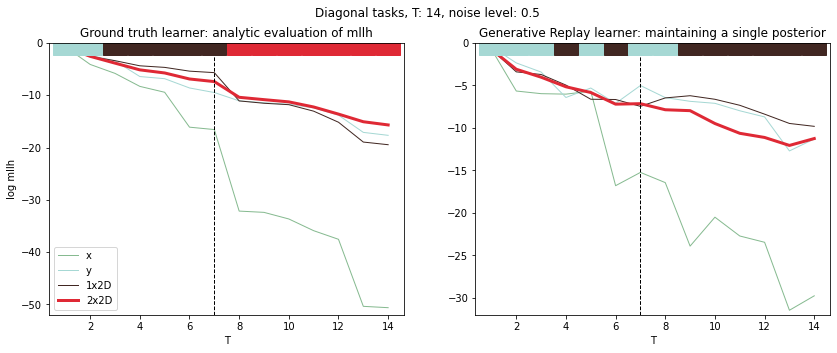

In [149]:
plottedModels = competingModels

competingModels = ["x", "y", "1x2D", "2x2D"]
competingModelIDs = [0, 1, 2, 4]

trueModel = "2x2D"


T = len(data["z"])

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("Diagonal tasks, T: " + str(T) + ", noise level: " + str(sigma_r))

for modelID in plottedModels:
    if modelID == trueModel:
        lw = 3
    else:
        lw = 1
    ax1.plot(range(1,T+1),np.log(mllhGT[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
    ax2.plot(range(1,T+1),np.log(mllhGR[competingModels.index(modelID)]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
ax1.legend(plottedModels, loc ="lower left")

yBottom=-52
ax1.set(title="Ground truth learner: analytic evaluation of mllh", ylabel="log mllh", xlabel="T", ylim=[yBottom,0])
ax1.plot([7,7],[yBottom, 0],'--', color="black", linewidth=1)

yBottom=-32
ax2.set(title="Generative Replay learner: maintaining a single posterior", xlabel="T", ylim=[yBottom,0])
ax2.plot([7,7],[yBottom, 0],'--', color="black", linewidth=1)



for t in range(0,T):
    ax1.plot(t+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGT[competingModelIDs,t])])], markersize = 24)
    ax2.plot(t+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGR[:,t])])], markersize = 24)


fig.set_figwidth(14)
fig.set_figheight(5)

In [151]:
fig.savefig('exp_gt_vs_gr_diagonal.pdf', facecolor=fig.get_facecolor(), transparent=False)

**EXPERIMENT**

**Testing a GR learner on 2-task data, cardinal condition**

* *GR with unkonwn bg*: we test the case when we assume that the GR does not know about the background, rather marginalization occurs for synthesized data

In [28]:
data1 = helper.generate_data(7, alpha = 90)
data2 = helper.generate_data(7, alpha = 0)
data = helper.concatenate_data(data1, data2)
T=np.size(data["z"],0)

**basic insight about the data**

evaluating mllh's at the last data point

In [32]:
sigma_r=0.7

mllhx, px = calc_mmllh_1task(data, sigma_r, model="x", evaluation = "full")
mllhy, p = calc_mmllh_1task(data, sigma_r, model="y", evaluation = "full")
mllh1x2D, p = calc_mmllh_1task(data, sigma_r, model="1x2D", evaluation = "full")
mllh2, p= calc_mmllh_2task(data, sigma_r, model="2x1D", evaluation = "full", marginalize=True)
mllh2bg, p= calc_mmllh_2task(data, sigma_r, model="2x1D", evaluation = "full", marginalize=False)
dataGRx = eval_learning.dream_data_from_posterior("x", T = 14, mu = px[0], Sigma = px[1])
mllhGRx, p= calc_mmllh_2task(dataGRx, sigma_r, model="2x1D", evaluation = "full", marginalize=True)

print("x", np.log(mllhx), ", y", np.log(mllhy), ", 1x2D", np.log(mllh1x2D), ", 2x1D", np.log(mllh2), ", 2x1Dbg", np.log(mllh2bg), ", 2x1DGRx", np.log(mllhGRx))

x -22.150828041903292 , y -25.467132769399566 , 1x2D -22.603460405184403 , 2x1D -14.485435408219034 , 2x1Dbg -7.1954529851437545 , 2x1DGRx -9.262307239033522


In [36]:
sigma_r=0.7

competingModels = ["x", "y", "1x2D", "2x1D"]
competingModelIDs = [0, 1, 2, 3]
mllhGTbg, pred_prob = eval_learning.learnGT(d,sigma_r,model_set=competingModels,marginalize=False)

mllhGTnobg, pred_prob = eval_learning.learnGT(d,sigma_r,model_set=competingModels,marginalize=True)

#mllhGR, evolvingModelGR = eval_learning.learnGR(d, 10, sigma_r,model_set=competingModels)
evolvingModelGR

['x',
 'x',
 'x',
 'x',
 '1x2D',
 '1x2D',
 '1x2D',
 'y',
 '1x2D',
 '1x2D',
 '1x2D',
 'y',
 'y',
 'y']

In [39]:
#with open('exp_gt_vs_gr_cardinal_gr_w_unknownbg.pkl', 'wb') as f:  
#    pickle.dump([data, sigma_r, competingModels, mllhGTbg, mllhGTnobg, mllhGR], f)

#with open('exp_gt_vs_gr_cardinal_gr_w_unknownbg.pkl', 'rb') as f:
#    data, sigma_r, competingModels, mllhGTbg, mllhGTnobg, mllhGR = pickle.load(f)

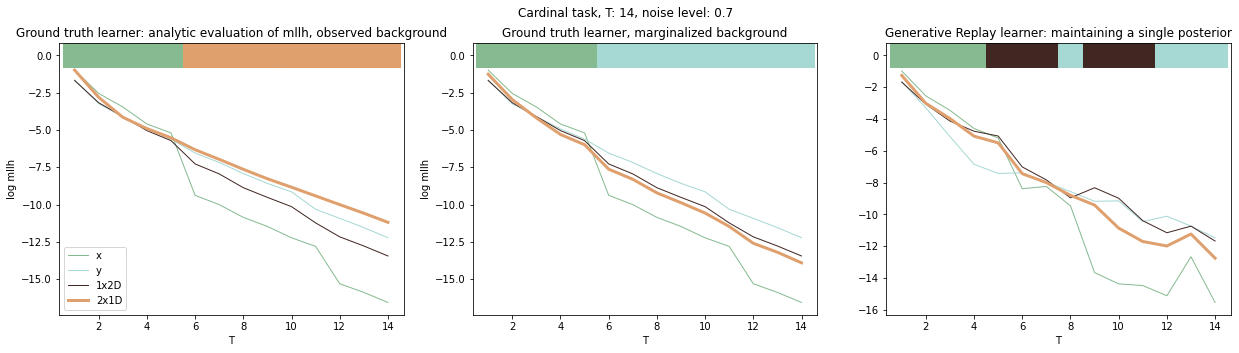

In [38]:
plottedModels = competingModels

trueModel = "2x1D"

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle("Cardinal task, T: " + str(T) + ", noise level: " + str(sigma_r))

for modelID in plottedModels:
    if modelID == trueModel:
        lw = 3
    else:
        lw = 1
    ax1.plot(range(1,T+1),np.log(mllhGTbg[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
    ax2.plot(range(1,T+1),np.log(mllhGTnobg[modelIDs.get(modelID)]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
    ax3.plot(range(1,T+1),np.log(mllhGR[competingModels.index(modelID)]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
ax1.legend(plottedModels, loc ="lower left")

ax1.set(title="Ground truth learner: analytic evaluation of mllh, observed background", ylabel="log mllh", xlabel="T")
ax2.set(title="Ground truth learner, marginalized background", ylabel="log mllh", xlabel="T")
ax3.set(title="Generative Replay learner: maintaining a single posterior", xlabel="T")

for t in range(0,T):
    ax1.plot(t+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGTbg[competingModelIDs,t])])], markersize = 24)
    ax2.plot(t+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGTnobg[competingModelIDs,t])])], markersize = 24)
    ax3.plot(t+1,0, 's', color=colorPalette[modelIDs.get(evolvingModelGR[t])], markersize = 24)

fig.set_figwidth(21)
fig.set_figheight(5)

In [40]:
#fig.savefig('exp_gt_vs_gr_cardinal_gr_w_unknownbg.png', facecolor=fig.get_facecolor(), transparent=False)

In [ ]:
mllh1 = calc_mmllh_2task(d, sigma_r, model="1x2D", evaluation = "full", Sigma_0=[[1,0],[0,1]])

**EXPERIMENT** 

**calculation of mutual information between *c* and *r***

Setting
* cardinal task is investigated
* we observe a pair pairs of data points from the two tasks (by default only one pair of points)
* posteriors are claculated between a 1-ask model (*x*) and the 2-task model
* GR is applied: using the parameter posterior we evaluate $\log \frac{p(r|x,c)}{p(r|x)}$
* we assess the total mutual information between task and reward by using the true model to calculate MI

In [425]:
data1 = helper.generate_data(1, alpha = 90)
data2 = helper.generate_data(1, alpha = 0)
data = helper.concatenate_data(data1, data2)

sigma_r=0.7

mllh, mu, Sigma = calc_mllh.calc_mmllh_1task(data, sigma_r, model="x", evaluation = "full", Sigma_0=1)
posteriorx = [mu, Sigma]

aa = calc_mllh.calc_mmllh_2task(data, sigma_r, model="2x1D", evaluation = "full", Sigma_0=1, num_particles = 256, marginalize = True)
mllh, posterior2x1D = aa


In [426]:
# lower baseline: generating r from a model that is completely wrong about the dependency bw z and r
Nr = 1000
lpr = np.zeros(Nr)
for i in range(0,Nr):
    dataTest = helper.generate_data(1, alpha = 90)
    lpr[i] = np.log(np.mean(scipy.stats.norm(dataTest["z"][0,0]*np.random.normal(posteriorx[0], posteriorx[1],1000), sigma_r).pdf(dataTest["r"][0])) / (0.5*np.mean(scipy.stats.norm(dataTest["z"][0,0]*np.random.normal(posteriorx[0], posteriorx[1],1000), sigma_r).pdf(dataTest["r"][0])) + 0.5 * np.mean(scipy.stats.norm(dataTest["z"][0,0]*np.random.normal(posteriorx[0], posteriorx[1],1000), sigma_r).pdf(dataTest["r"][0]))))
mi_x = np.mean(lpr)
print('mutual information bw z and r for a wrong model', mi_x)


#upper baseline: assessing the real rewards
Nr = 1000
lpr = np.zeros(Nr)

for i in range(0,Nr):
    dataTest = helper.generate_data(1, alpha = 90)
    lpr[i] = np.log(scipy.stats.norm(dataTest["z"][0,1], sigma_r).pdf(dataTest["r"][0])/np.mean(scipy.stats.norm(dataTest["z"][0,:], sigma_r).pdf(dataTest["r"][0])))
mi_2x1D_GT = np.mean(lpr)
print('mutual information bw z and r for the true model', mi_2x1D_GT)

#assessing when rewards are sampled from the parameter posterior
Nr = 1000
lpr = np.zeros(Nr)

#samples from gamma
gammaSamples = np.zeros(Nr)
gammaSamples2 = np.zeros(Nr)
ks = np.random.multinomial(Nr, posterior2x1D[2])
for ki in range(0,np.size(ks,0)):
    if ks[ki]>0:
        iFirst=np.sum(ks[0:ki])
        iLast=np.sum(ks[0:ki+1])
        gammaSamples[iFirst:iLast] = np.random.normal(posterior2x1D[0][ki][1],posterior2x1D[1][ki][1],ks[ki])
        gammaSamples2[iFirst:iLast] = np.random.normal(posterior2x1D[0][ki][0],posterior2x1D[1][ki][0],ks[ki])

for i in range(0,Nr):
    dataTest = helper.generate_data(1, alpha = 90)
    lpr[i] = np.log(np.mean(scipy.stats.norm(dataTest["z"][0,1]*gammaSamples, sigma_r).pdf(dataTest["r"][0])) / (0.5 * np.mean(scipy.stats.norm(dataTest["z"][0,1]*gammaSamples, sigma_r).pdf(dataTest["r"][0])) + 0.5 * np.mean(scipy.stats.norm(dataTest["z"][0,0]*gammaSamples2, sigma_r).pdf(dataTest["r"][0]))))
mi_2x1D_post = np.mean(lpr)
print('mutual information bw z and r for the right model but using the parameter posterior', mi_2x1D_post)


mutual information bw z and r for a wrong model 0.0005052264526598
mutual information bw z and r for the true model 0.3627537677363023
mutual information bw z and r for the right model but using the parameter posterior 0.23812367650876204


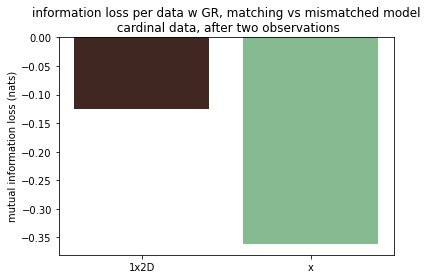

In [427]:
model_names = ["1x2D", "x"]

fig, ax = plt.subplots(1,1)

plt.bar(model_names, [mi_2x1D_post - mi_2x1D_GT, mi_x - mi_2x1D_GT], color=[colorPalette[modelIDs.get(model_names[0])], colorPalette[modelIDs.get(model_names[1])]] )
plt.ylabel('mutual information loss (nats)')
#plt.title(print("aa", mllhy))
plt.title("information loss per data w GR, matching vs mismatched model\n cardinal data, after two observations")
plt.show()

In [558]:
import sys

Ndata = 100

sigma_r=0.5

mi_x = np.zeros(Ndata)
mi_2x1D_GT = np.zeros(Ndata)
mi_2x1D_post = np.zeros(Ndata)
for nd in range(0,Ndata):
    sys.stdout.write('\r')
    
    #print(nd)
    data1 = helper.generate_data(1, alpha = 90)
    data2 = helper.generate_data(1, alpha = 0)
    data = helper.concatenate_data(data1, data2)

    mllh, mu, Sigma = calc_mllh.calc_mmllh_1task(data, sigma_r, model="x", evaluation = "full", Sigma_0=1)
    posteriorx = [mu, Sigma]

    aa = calc_mllh.calc_mmllh_2task(data, sigma_r, model="2x1D", evaluation = "full", Sigma_0=1, num_particles = 256, marginalize = True)
    mllh, posterior2x1D = aa

    # lower baseline: generating r from a model that is completely wrong about the dependency bw z and r
    Nr = 1000
    lpr = np.zeros(Nr)
    for i in range(0,Nr):
        dataTest = helper.generate_data(1, alpha = 90)
        lpr[i] = np.log(np.mean(scipy.stats.norm(dataTest["z"][0,0]*np.random.normal(posteriorx[0], posteriorx[1],1000), sigma_r).pdf(dataTest["r"][0])) / (0.5*np.mean(scipy.stats.norm(dataTest["z"][0,0]*np.random.normal(posteriorx[0], posteriorx[1],1000), sigma_r).pdf(dataTest["r"][0])) + 0.5 * np.mean(scipy.stats.norm(dataTest["z"][0,0]*np.random.normal(posteriorx[0], posteriorx[1],1000), sigma_r).pdf(dataTest["r"][0]))))
    mi_x[nd] = np.mean(lpr)

    #upper baseline: assessing the real rewards
    Nr = 1000
    lpr = np.zeros(Nr)

    for i in range(0,Nr):
        dataTest = helper.generate_data(1, alpha = 90)
        lpr[i] = np.log(scipy.stats.norm(dataTest["z"][0,1], sigma_r).pdf(dataTest["r"][0])/np.mean(scipy.stats.norm(dataTest["z"][0,:], sigma_r).pdf(dataTest["r"][0])))
    mi_2x1D_GT[nd] = np.mean(lpr)

    #assessing when rewards are sampled from the parameter posterior
    Nr = 1000
    lpr = np.zeros(Nr)

    #samples from gamma
    gammaSamples = np.zeros(Nr)
    gammaSamples2 = np.zeros(Nr)
    ks = np.random.multinomial(Nr, posterior2x1D[2])
    for ki in range(0,np.size(ks,0)):
        if ks[ki]>0:
            iFirst=np.sum(ks[0:ki])
            iLast=np.sum(ks[0:ki+1])
            gammaSamples[iFirst:iLast] = np.random.normal(posterior2x1D[0][ki][1],posterior2x1D[1][ki][1],ks[ki])
            gammaSamples2[iFirst:iLast] = np.random.normal(posterior2x1D[0][ki][0],posterior2x1D[1][ki][0],ks[ki])

    for i in range(0,Nr):
        dataTest = helper.generate_data(1, alpha = 90)
        lpr[i] = np.log(np.mean(scipy.stats.norm(dataTest["z"][0,1]*gammaSamples, sigma_r).pdf(dataTest["r"][0])) / (0.5 * np.mean(scipy.stats.norm(dataTest["z"][0,1]*gammaSamples, sigma_r).pdf(dataTest["r"][0])) + 0.5 * np.mean(scipy.stats.norm(dataTest["z"][0,0]*gammaSamples2, sigma_r).pdf(dataTest["r"][0]))))
    mi_2x1D_post[nd] = np.mean(lpr)
    
    # print loss and accuracy

    sys.stdout.write("[%-60s] %d%%" % ('='*int(60*(nd+1)/100), int(100*(nd+1)/100)))
    sys.stdout.flush()
    #sys.stdout.write(", epoch %d"% (nd+1))
    sys.stdout.flush()


[============================================================] 100%

In [152]:
#with open('exp_information_loss_cardinal.pkl', 'wb') as f:  
#    pickle.dump([miLoss], f)

#with open('exp_information_loss_cardinal.pkl', 'rb') as f:
#    miLoss = pickle.load(f)

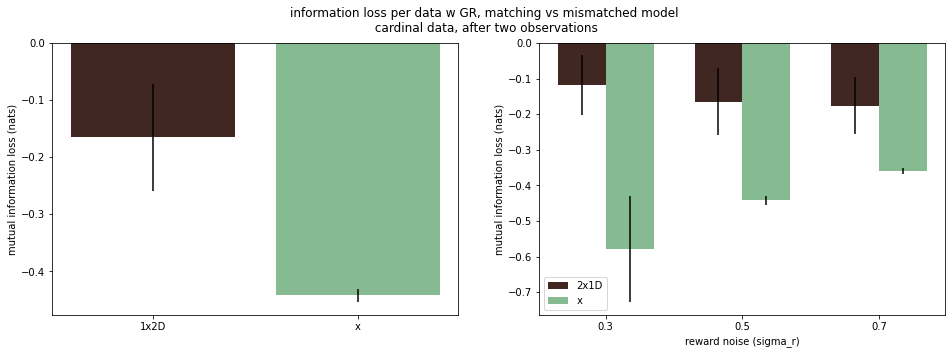

In [165]:
model_names = ["1x2D", "x"]

sigma_rs = miLoss[0]['sigma_r']

fig, (ax1, ax2) = plt.subplots(1,2)

#mi_xLoss = [np.mean(miLoss["mi_x"][0]-miLoss["mi_2x1D_GT"][0]), np.mean(miLoss["mi_x"][1]-miLoss["mi_2x1D_GT"][1]), np.mean(miLoss["mi_x"][2]-miLoss["mi_2x1D_GT"][2])]
mi_xLoss = [np.mean(miLoss[0]["mi_x"][0]-miLoss[0]["mi_2x1D_GT"][0]), np.mean(miLoss[0]["mi_x"][1]-miLoss[0]["mi_2x1D_GT"][1]), np.mean(miLoss[0]["mi_x"][2]-miLoss[0]["mi_2x1D_GT"][2])]
#mi_xLossErr = [np.std(miLoss["mi_x"][0]-miLoss["mi_2x1D_GT"][0]), np.std(miLoss["mi_x"][1]-miLoss["mi_2x1D_GT"][1]), np.std(miLoss["mi_x"][2]-miLoss["mi_2x1D_GT"][2])]
mi_xLossErr = [np.std(miLoss[0]["mi_x"][0]-miLoss[0]["mi_2x1D_GT"][0]), np.std(miLoss[0]["mi_x"][1]-miLoss[0]["mi_2x1D_GT"][1]), np.std(miLoss[0]["mi_x"][2]-miLoss[0]["mi_2x1D_GT"][2])]
mi_2x1DLoss = [np.mean(miLoss[0]["mi_2x1D_post"][0]-miLoss[0]["mi_2x1D_GT"][0]), np.mean(miLoss[0]["mi_2x1D_post"][1]-miLoss[0]["mi_2x1D_GT"][1]), np.mean(miLoss[0]["mi_2x1D_post"][2]-miLoss[0]["mi_2x1D_GT"][2])]
#mi_2x1DLoss = [np.mean(miLoss["mi_2x1D_post"][0]-miLoss["mi_2x1D_GT"][0]), np.mean(miLoss["mi_2x1D_post"][1]-miLoss["mi_2x1D_GT"][1]), np.mean(miLoss["mi_2x1D_post"][2]-miLoss["mi_2x1D_GT"][2])]
mi_2x1DLossErr = [np.std(miLoss[0]["mi_2x1D_post"][0]-miLoss[0]["mi_2x1D_GT"][0]), np.std(miLoss[0]["mi_2x1D_post"][1]-miLoss[0]["mi_2x1D_GT"][1]), np.std(miLoss[0]["mi_2x1D_post"][2]-miLoss[0]["mi_2x1D_GT"][2])]

ax1.bar(model_names, [mi_2x1DLoss[1], mi_xLoss[1]], yerr=[mi_2x1DLossErr[1], mi_xLossErr[1]], color=[colorPalette[modelIDs.get(model_names[0])], colorPalette[modelIDs.get(model_names[1])]] )
ax1.set(ylabel="mutual information loss (nats)")

x = np.arange(len(miLoss[0]["sigma_r"]))
width = 0.35

rects1 = ax2.bar(x - width/2, mi_2x1DLoss, width, yerr=mi_2x1DLossErr, label='2x1D', color=colorPalette[modelIDs.get(model_names[0])])
rects2 = ax2.bar(x + width/2, mi_xLoss, width, yerr=mi_xLossErr, label='x', color=colorPalette[modelIDs.get(model_names[1])])

ax2.set_ylabel('mutual information loss (nats)')
ax2.set_xlabel('reward noise (sigma_r)')
ax2.set_xticks(x)
ax2.set_xticklabels(sigma_rs)
ax2.legend()

#ax2.bar_label(rects1, padding=3)
#ax2.bar_label(rects2, padding=3)

plt.suptitle("information loss per data w GR, matching vs mismatched model\n cardinal data, after two observations")

fig.set_figwidth(16)
fig.set_figheight(5)
plt.show()

In [167]:
#fig.savefig('exp_information_loss_cardinal.png', facecolor=fig.get_facecolor(), transparent=False)

****
**EXPERIMENT**

**model switching after task switch**

In [100]:
lengthTask1 = 10
lengthTask2 = 10
data1 = helper.generate_data(lengthTask1, alpha = 45)
data2 = helper.generate_data(lengthTask2, alpha = -45)
data = helper.concatenate_data(data1, data2)
T=np.size(data["z"],0)

In [130]:
sigma_r=0.8

T0 =lengthTask1
competingModels = ["x", "y", "1x2D", "2x2D"]
competingModelIDs = [0, 1, 2, 4]
mllhGTbg, pred_prob = eval_learning.learnGT(data,sigma_r,model_set=competingModels,marginalize=False, T0 = T0)

mllhGTnobg, pred_prob = eval_learning.learnGT(data,sigma_r,model_set=competingModels,marginalize=True, T0 = T0)


In [132]:
#with open('exp_switchtime_diagonal_example.pkl', 'wb') as f:  
#    pickle.dump([mllhGTbg, mllhGTnobg, lengthTask1, lengthTask2, data, T, competingModels, competingModelIDs, sigma_r], f)

#with open('exp_switchtime_diagonal_example.pkl', 'rb') as f:
#    mllhGTbg, mllhGTnobg, lengthTask1, lengthTask2, data, T, competingModels, competingModelIDs, sigma_r = pickle.load(f)

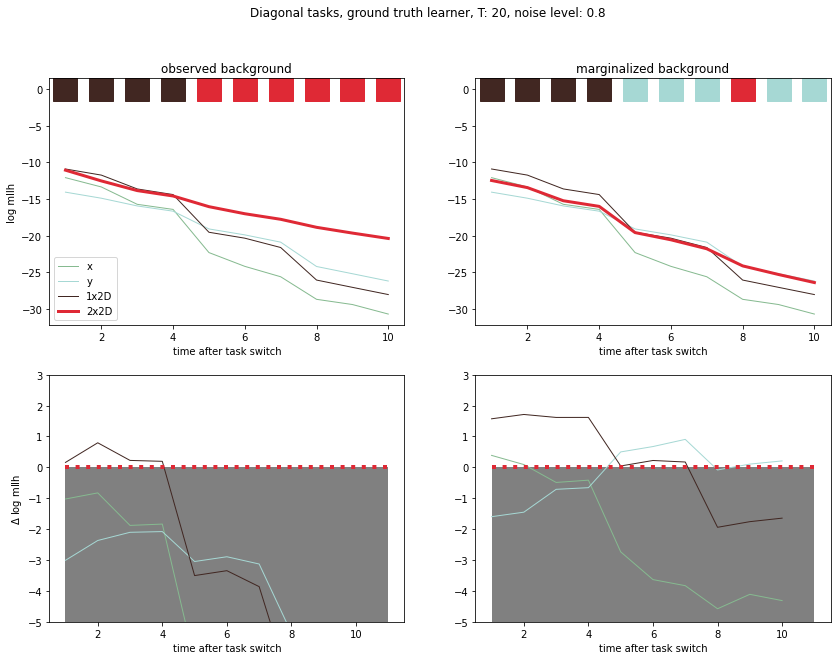

In [131]:
from matplotlib.patches import Rectangle

plottedModels = competingModels

competingModels = ["x", "y", "1x2D", "2x2D"]
competingModelIDs = [0, 1, 2, 4]

trueModel = "2x2D"


T = len(data["z"])

fig, ax = plt.subplots(2,2)
fig.suptitle("Diagonal tasks, ground truth learner, T: " + str(T) + ", noise level: " + str(sigma_r))

for modelID in plottedModels:
    if modelID == trueModel:
        lw = 3
    else:
        lw = 1
    ax[0,0].plot(range(1,T-T0+1),np.log(mllhGTbg[modelIDs.get(modelID),T0:T]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
    ax[0,1].plot(range(1,T-T0+1),np.log(mllhGTnobg[modelIDs.get(modelID),T0:T]),color=colorPalette[modelIDs.get(modelID)], linewidth=lw)
ax[0,0].legend(plottedModels, loc ="lower left")

ax[0,0].set(title="observed background", ylabel="log mllh", xlabel="time after task switch")
ax[0,1].set(title="marginalized background", xlabel="time after task switch")

for t in range(T0,T):
    ax[0,0].plot(t-T0+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGTbg[competingModelIDs,t])])], markersize = 24)
    ax[0,1].plot(t-T0+1,0, 's', color=colorPalette[modelIDs.get(competingModels[np.argmax(mllhGTnobg[competingModelIDs,t])])], markersize = 24)

alternativeModels = ["x", "y", "1x2D"]
alternativeModelIDs = [1, 2, 3]
   
for modelID in alternativeModels:
    ax[1,0].plot(range(1,T-T0+1),np.log(mllhGTbg[modelIDs.get(modelID),T0:T]) - np.log(mllhGTbg[modelIDs.get(trueModel),T0:T]),color=colorPalette[modelIDs.get(modelID)], linewidth=1)
    ax[1,1].plot(range(1,T-T0+1),np.log(mllhGTnobg[modelIDs.get(modelID),T0:T]) - np.log(mllhGTnobg[modelIDs.get(trueModel),T0:T]),color=colorPalette[modelIDs.get(modelID)], linewidth=1)

yTop = 3
yBottom = -5

ax[1,0].add_patch(Rectangle((1, 0), lengthTask2, yBottom,
             facecolor = [0.5, 0.5, 0.5],
             fill=True,
             lw=0))
ax[1,1].add_patch(Rectangle((1, 0), lengthTask2, yBottom,
             facecolor = [0.5, 0.5, 0.5],
             fill=True,
             lw=0))


ax[1,0].plot([1,T-T0+1], [0, 0],':', color=colorPalette[modelIDs.get(trueModel)], linewidth=4)
ax[1,1].plot([1,T-T0+1], [0, 0],':', color=colorPalette[modelIDs.get(trueModel)], linewidth=4)

ax[1,0].set(ylabel="$\Delta$ log mllh", xlabel="time after task switch", ylim=[yBottom,yTop])
ax[1,1].set(xlabel="time after task switch", ylim=[yBottom,yTop])

    
fig.set_figwidth(14)
fig.set_figheight(10)

In [133]:
#fig.savefig('exp_switchtime_diagonal_example.png', facecolor=fig.get_facecolor(), transparent=False)

**assessing the distribution of switching times**

* diagonal task, as above

In [ ]:
lengthTask1 = 10
lengthTask2 = 10

Ndataset = 100

sigma_r=0.8

competingModels = ["x", "y", "1x2D", "2x2D"]
competingModelIDs = [0, 1, 2, 4]

trueModel = "2x2D"

Tswitchbg = np.zeros(Ndataset)
Tswitchnobg = np.zeros(Ndataset)
for n in range(0,Ndataset):
    sys.stdout.write('\r')
    data1 = helper.generate_data(lengthTask1, alpha = 45)
    data2 = helper.generate_data(lengthTask2, alpha = -45)
    data = helper.concatenate_data(data1, data2)
    T=np.size(data["z"],0)

    T0 =lengthTask1
    
    mllhGTbg, pred_prob = eval_learning.learnGT(data,sigma_r,model_set=competingModels,marginalize=False, T0 = T0)
    winnerTrue = np.where(np.argmax(mllhGTbg[competingModelIDs,T0:T],0)==competingModels.index(trueModel))
    if len(winnerTrue[0]):
        Tswitchbg[n] = winnerTrue[0][0]
    else:
        Tswitchbg[n] = lengthTask2+1
    mllhGTnobg, pred_prob = eval_learning.learnGT(data,sigma_r,model_set=competingModels,marginalize=True, T0 = T0)
    winnerTrue = np.where(np.argmax(mllhGTnobg[competingModelIDs,T0:T],0)==competingModels.index(trueModel))
    if len(winnerTrue[0]):
        Tswitchnobg[n] = winnerTrue[0][0]
    else:
        Tswitchnobg[n] = lengthTask2+1

    sys.stdout.write("[%-60s] %d%%" % ('='*int(60*(n+1)/100), int(100*(n+1)/100)))
    sys.stdout.flush()
    #sys.stdout.write(", epoch %d"% (nd+1))
    sys.stdout.flush()


In [205]:
#exp2={"lengthTask1": lengthTask1, "lengthTask2": lengthTask2, "Tswitchbg": Tswitchbg, "Tswitchnobg": Tswitchnobg, "Ndataset": Ndataset, "competingModels": competingModels, "competingModelIDs": competingModelIDs, "sigma_r": sigma_r}

In [206]:
#expSwitchingTimeDiag = [exp1, exp2, exp3, exp4, exp5, exp6, exp7, exp8, exp9, exp10]

In [207]:
#with open('exp_switchtime_diagonal_hist.pkl', 'wb') as f:  
#    pickle.dump([expSwitchingTimeDiag], f)

#with open('exp_switchtime_diagonal_hist.pkl', 'rb') as f:
#    expSwitchingTimeDiag = pickle.load(f)

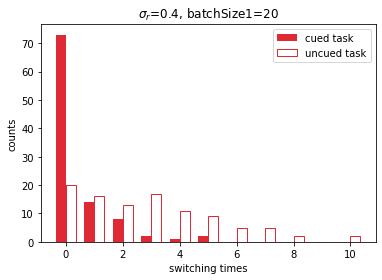

In [137]:
expID=9
lengthTask1 = expSwitchingTimeDiag[expID]["lengthTask1"]
lengthTask2 = expSwitchingTimeDiag[expID]["lengthTask2"]
Tswitchbg = expSwitchingTimeDiag[expID]["Tswitchbg"]
Tswitchnobg = expSwitchingTimeDiag[expID]["Tswitchnobg"]
sigma_r = expSwitchingTimeDiag[expID]["sigma_r"]
Ndataset = expSwitchingTimeDiag[expID]["Ndataset"]
expSwitchingTimeDiag[expID]

countsbg, binsbg = np.histogram(Tswitchbg,range(0,12))
countsnobg, binsnobg = np.histogram(Tswitchnobg,range(0,12))

width = 0.35

rects1 = plt.bar(binsbg[0:11] - width/2, countsbg, width, label='cued task', color=colorPalette[modelIDs.get('2x2D')])
rects2 = plt.bar(binsbg[0:11] + width/2, countsnobg, width, label='uncued task', edgecolor=colorPalette[modelIDs.get('2x2D')], facecolor='white')

plt.title("$\sigma_r$=" + str(sigma_r) + ", batchSize1=" + str(lengthTask1))
plt.ylabel('counts')
plt.xlabel('switching times')
#plt.set_xticks(x)
plt.legend()

plt.show()


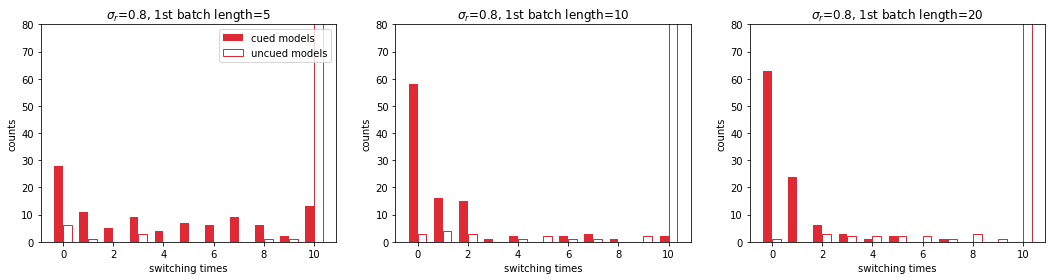

In [272]:
#expIDs=[4, 3, 5]
#expIDs=[7, 8, 9]
expIDs=[0,1,2]

fig, ax = plt.subplots(1,3)

width = 0.35

for i in range(0,3):
    expID = expIDs[i]
    lengthTask1 = expSwitchingTimeDiag[expID]["lengthTask1"]
    lengthTask2 = expSwitchingTimeDiag[expID]["lengthTask2"]
    Tswitchbg = expSwitchingTimeDiag[expID]["Tswitchbg"]
    Tswitchnobg = expSwitchingTimeDiag[expID]["Tswitchnobg"]
    sigma_r = expSwitchingTimeDiag[expID]["sigma_r"]
    Ndataset = expSwitchingTimeDiag[expID]["Ndataset"]
    expSwitchingTimeDiag[expID]

    countsbg, binsbg = np.histogram(Tswitchbg,range(0,12))
    countsnobg, binsnobg = np.histogram(Tswitchnobg,range(0,12))

    rects1 = ax[i].bar(binsbg[0:11] - width/2, countsbg, width, label='cued task', color=colorPalette[modelIDs.get('2x2D')])
    rects2 = ax[i].bar(binsbg[0:11] + width/2, countsnobg, width, label='uncued task', edgecolor=colorPalette[modelIDs.get('2x2D')], facecolor='white')

    ax[i].set(title="$\sigma_r$=" + str(sigma_r) + ", 1st batch length=" + str(lengthTask1), ylabel='counts', xlabel='switching times', ylim=[0, 80])
    #ax[0].settitle()
    #plt.ylabel()
    #plt.xlabel()
    #plt.set_xticks(x)
    #plt.legend()


ax[0].legend(["cued models", "uncued models"], loc ="upper right")
    
fig.set_figwidth(18)
fig.set_figheight(4)
plt.show()



In [100]:
#fig.savefig('exp_switchtime_diagonal_hist.png', facecolor=fig.get_facecolor(), transparent=False)

**Performing the analysis for switching time distributions for the uncued task condition only**

* $\sigma_r$ is 0.4

In [218]:
expIDs=[0, 1, 2]
#expIDs=[4, 3, 5]
#expIDs=[7, 8, 9]

TswitchbgMean = np.zeros(3)
blockLengths = np.zeros(3)
for i in range(0,3):
    expID = expIDs[i]
    Tswitchbg = expSwitchingTimeDiag[expID]["Tswitchbg"]
    blockLengths[i]=expSwitchingTimeDiag[expID]["lengthTask1"]
    TswitchbgMean[i] = np.mean(Tswitchbg)

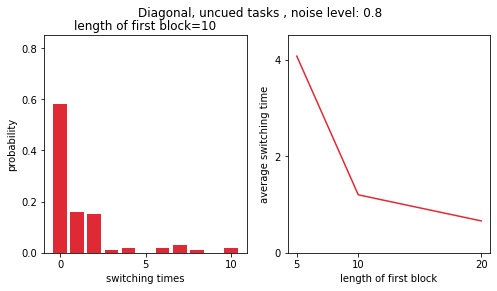

In [269]:
fig, ax = plt.subplots(1,2)

width = 0.8

expID = expIDs[1]
lengthTask1 = expSwitchingTimeDiag[expID]["lengthTask1"]
lengthTask2 = expSwitchingTimeDiag[expID]["lengthTask2"]
Tswitchbg = expSwitchingTimeDiag[expID]["Tswitchbg"]
Tswitchnobg = expSwitchingTimeDiag[expID]["Tswitchnobg"]
sigma_r = expSwitchingTimeDiag[expID]["sigma_r"]
Ndataset = expSwitchingTimeDiag[expID]["Ndataset"]
expSwitchingTimeDiag[expID]

countsbg, binsbg = np.histogram(Tswitchbg,range(0,12))

rects1 = ax[0].bar(binsbg[0:11], countsbg/100, width, label='cued task', color=colorPalette[modelIDs.get('2x2D')])

ax[0].set(title="length of first block=" + str(lengthTask1), ylabel='probability', xlabel='switching times', ylim=[0, 0.85], xticks=[0, 5, 10], yticks=[0, 0.2, 0.4, 0.6, 0.8])

ax[1].plot(blockLengths,TswitchbgMean,color=colorPalette[modelIDs.get("2x2D")])
ax[1].set(ylim=[0,4.5], xticks=[5, 10,20], yticks=[0, 2, 4], xlabel="length of first block", ylabel="average switching time")

fig.set_figwidth(8)
fig.set_figheight(4)

fig.suptitle("Diagonal, uncued tasks , noise level: " + str(sigma_r))

plt.show()

In [271]:
#fig.savefig('exp_switchtime_diagonal_compact.png', facecolor=fig.get_facecolor(), transparent=False)

**EXPLORATION**

**Learning through a number of batches**